This example will show how to generate the Markov chain-based analysis from [1] using the MindScoPy package. The notebook will walk you through analyzing a single individual from the BCI Competition IV-2a dataset. See the `bci_comp_iv2a_preprocessing.py` file for data preprocessing and preparation steps.

[1] Ivanov, N, Lio, A., and Chau. T. (2023). Towards user-centric
        BCI design: Markov chain-based user assessment for mental-imagery EEG-BCIs.
        Journal of Neural Engineering, 20(6). https://doi.org/10.1088/1741-2552/ad17f2

In [1]:
import mindscopy as ms
from mindscopy.preprocessing.artifact_removal import peak_rejection, riemannian_potato_rejection
from mindscopy.preprocessing.misc import epoch
from mindscopy.preprocessing.rebias import apply_rebias_to_groups
from mindscopy.preprocessing.feature_extraction import ScaledTangentSpace
import numpy as np
import pyriemann
import pickle


In [2]:
# load the preprocessed (bandpass filtered and epoched) BCI Competition IV 2a data
with open('data/BCI_Comp_IV_2a/preprocessed_data.pkl', 'rb') as f:
    d = pickle.load(f)


In [3]:
# select data from one person
p = 9

# Extract all data from both sessions
X = np.concatenate([d[p][1]['trials'], d[p][2]['trials']])
y = np.concatenate([d[p][1]['labels'], d[p][2]['labels']])
blocks = np.concatenate([
    d[p][1]['run_labels'], 
    d[p][2]['run_labels']+(1+max(d[p][1]['run_labels'])) # shift the second session's block labels
])


Perform the preprocessing steps of artifact rejecting and sub-epoching.

In [4]:
print(X.shape)
print(np.unique(y))

(501, 22, 1501)
[1 2 3 4]


In [5]:
# split trials into rest and task epochs
Fs = 250
length = 3 * Fs
stride = 3 * Fs
X = epoch(X, length, stride)
Xtask = X[:,1,:,:]
Xrest = X[:,0,:,:]
y_rest = np.zeros((Xrest.shape[0],))

# concatenate rest and task epochs
X = np.concatenate([Xtask, Xrest])
y = np.concatenate([y, y_rest])
blocks = np.concatenate([blocks, blocks])

In [6]:
print(X.shape)

(1002, 22, 750)


In [7]:
# apply peak rejection
X, rejected_trials = peak_rejection(X, threshold=100, verbose=True)
y = np.delete(y, rejected_trials)
blocks = np.delete(blocks, rejected_trials)


0 trials rejected.


In [8]:
# apply riemannian potato rejection to each block of trials
clean_X = []
clean_y = []
clean_blocks = []
for block in np.unique(blocks):
    block_idx = blocks == block
    X_block = X[block_idx]
    y_block = y[block_idx]
    blocks_block = blocks[block_idx]

    X_block, rejected_trials = riemannian_potato_rejection(X_block, threshold=2.5, verbose=True)
    y_block = np.delete(y_block, rejected_trials)
    blocks_block = np.delete(blocks_block, rejected_trials)

    clean_X.append(X_block)
    clean_y.append(y_block)
    clean_blocks.append(blocks_block)

X = np.concatenate(clean_X)
y = np.concatenate(clean_y)
blocks = np.concatenate(clean_blocks)

Potato filtering: 1 trials rejected.
Potato filtering: 3 trials rejected.
Potato filtering: 4 trials rejected.
Potato filtering: 8 trials rejected.
Potato filtering: 6 trials rejected.
Potato filtering: 5 trials rejected.
Potato filtering: 25 trials rejected.
Potato filtering: 13 trials rejected.
Potato filtering: 7 trials rejected.
Potato filtering: 12 trials rejected.
Potato filtering: 7 trials rejected.
Potato filtering: 9 trials rejected.


Now compute the mean covariance matrix for each block. These will be used for rebiasing the sub-epoch covariance matrices.

In [9]:
n_trials, n_channels, n_samples = X.shape
n_blks = len(np.unique(blocks))

# block means
block_means = np.zeros((n_blks, n_channels, n_channels))
for i, block in enumerate(np.sort(np.unique(blocks))):
    block_covs = pyriemann.utils.covariance.covariances(X[blocks == block])
    block_means[i] = pyriemann.utils.mean.mean_covariance(block_covs)

In [10]:
# Generate sub-epochs for each trial
length = 1
stride = 0.5
n_samples_epoch = int(Fs * length)
X_epoched = epoch(X, n_samples_epoch, int(Fs * stride))
n_epochs = X_epoched.shape[1]

In [11]:
# apply the rebiasing to the sub-epochs
blocks_clust_epochs = np.repeat(blocks, X_epoched.shape[1])

X_epoched = np.reshape(X_epoched, (-1, n_channels, n_samples_epoch))
X_epoch_covs = pyriemann.utils.covariance.covariances(X_epoched)

X_epoch_covs = apply_rebias_to_groups(X_epoch_covs, blocks_clust_epochs, block_means)

In [12]:
y_seg = np.repeat(y, n_epochs)
X_task_covs = X_epoch_covs[y_seg != 0]

Extract the Riemannian tangent space features to be used for the clustering analysis.

In [13]:
# apply feature extraction
feature_extractor = ScaledTangentSpace().fit(X_epoch_covs)
X_features = feature_extractor.transform(X_epoch_covs)

feature_extractor.fit(X_task_covs)
X_task_features = feature_extractor.transform(X_task_covs)

In [14]:
# put the data back into trial, epoch, format
X_features = np.reshape(X_features, (n_trials, n_epochs, -1))
Ntask_trials = np.sum(y != 0)
X_task_features = np.reshape(X_task_features, (Ntask_trials, n_epochs, -1))


Perform clustering and generate the trajectory sub-space

In [15]:
np.random.seed(42)
all_state_space = ms.MarkovStateSpace(krange=range(3,8)).fit(X_features, verbose=True)

# create a state space for the task data only
task_state_space = ms.MarkovStateSpace(krange=range(3,8)).fit(X_task_features, verbose=True)

Selecting the number of clusters using prediction strength.
Prediction strength criterion for k selection:
[0.7296943  0.44711023 0.41535709 0.37456779 0.31095756]
Number of clusters selected: 7
Selecting the number of clusters using prediction strength.
Prediction strength criterion for k selection:
[0.72538805 0.4408091  0.34975595 0.26615805 0.25284856]
Number of clusters selected: 5


Visulize the pattern state activation patterns

In [16]:
chs = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
ch_map = {
    ch : i for _, ch in enumerate(chs)
}

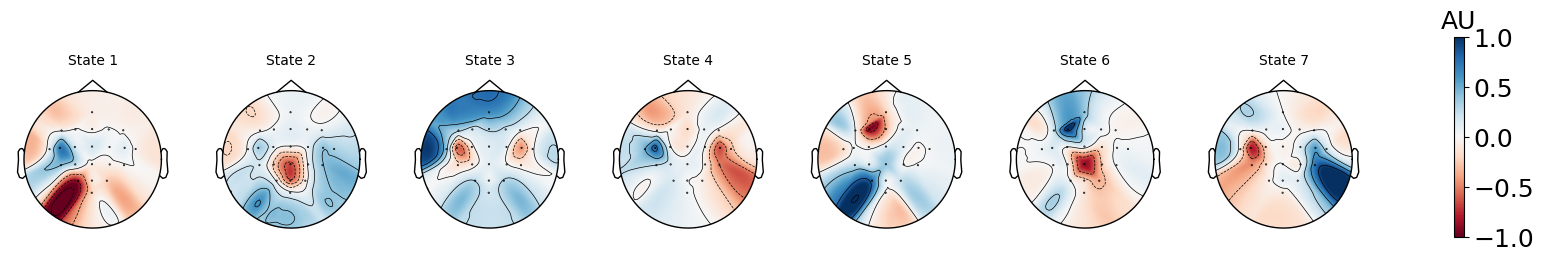

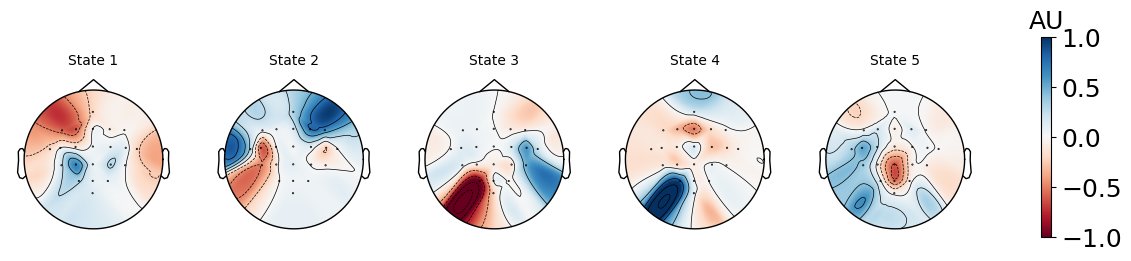

In [ ]:
all_state_space.plot_activation_patterns(np.reshape(X_features, (-1, X_features.shape[-1])), X_epoch_covs, list(ch_map.keys()))
task_state_space.plot_activation_patterns(np.reshape(X_task_features, (-1, X_task_features.shape[-1])), X_task_covs, list(ch_map.keys()))

Create Markov Chain Transition Matrices for each task

In [18]:
ytask = y[y != 0]
labels = np.unique(ytask)
models = [None] * len(labels)
for i, label in enumerate(labels):
    Xlabel = X_task_features[ytask == label]
    S = task_state_space.transform(Xlabel)
    models[i] = ms.MarkovChainModel(task_state_space).fit(S, verbose=True)

Transition matrix:
[[0.269 0.178 0.178 0.196 0.178]
 [0.024 0.639 0.199 0.080 0.059]
 [0.127 0.054 0.602 0.163 0.054]
 [0.171 0.189 0.171 0.299 0.171]
 [0.171 0.207 0.244 0.171 0.207]]
Transition matrix:
[[0.320 0.142 0.231 0.174 0.133]
 [0.025 0.616 0.212 0.077 0.070]
 [0.085 0.119 0.602 0.065 0.129]
 [0.169 0.169 0.218 0.299 0.145]
 [0.111 0.249 0.241 0.103 0.297]]
Transition matrix:
[[0.269 0.167 0.214 0.191 0.160]
 [0.119 0.376 0.166 0.150 0.189]
 [0.133 0.117 0.468 0.125 0.156]
 [0.102 0.102 0.133 0.499 0.164]
 [0.027 0.089 0.110 0.072 0.703]]
Transition matrix:
[[0.670 0.030 0.082 0.193 0.026]
 [0.165 0.279 0.211 0.188 0.157]
 [0.232 0.141 0.369 0.126 0.133]
 [0.160 0.081 0.096 0.646 0.017]
 [0.176 0.176 0.206 0.198 0.244]]


Compute the final performance metrics

0.24960785153329132


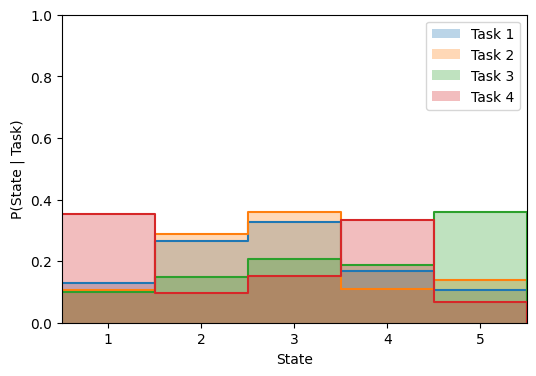

In [19]:
# compute the taskDistinct
td = ms.task_distinct(models, visualize=True)
print(td)

In [20]:
# create a Markov State Transition Matrix for all tasks and rest
models = [None] * (len(labels) + 1)
for i, label in enumerate(labels):
    Xlabel = X_features[y == label]
    S = all_state_space.transform(Xlabel)
    models[i] = ms.MarkovChainModel(all_state_space).fit(S, verbose=True)
S = all_state_space.transform(X_features[y == 0])
models[-1] = ms.MarkovChainModel(all_state_space).fit(S, verbose=True)

Transition matrix:
[[0.450 0.117 0.066 0.092 0.117 0.092 0.066]
 [0.154 0.205 0.128 0.128 0.128 0.128 0.128]
 [0.069 0.025 0.540 0.220 0.034 0.034 0.078]
 [0.197 0.070 0.113 0.408 0.155 0.028 0.028]
 [0.139 0.114 0.114 0.114 0.293 0.114 0.114]
 [0.161 0.110 0.136 0.110 0.136 0.238 0.110]
 [0.168 0.117 0.092 0.117 0.092 0.117 0.296]]
Transition matrix:
[[0.566 0.105 0.025 0.087 0.114 0.060 0.043]
 [0.169 0.362 0.055 0.180 0.067 0.067 0.101]
 [0.071 0.060 0.321 0.265 0.083 0.083 0.117]
 [0.120 0.109 0.120 0.427 0.097 0.063 0.063]
 [0.141 0.096 0.073 0.118 0.312 0.130 0.130]
 [0.151 0.140 0.117 0.151 0.094 0.231 0.117]
 [0.141 0.048 0.193 0.079 0.028 0.038 0.472]]
Transition matrix:
[[0.387 0.104 0.060 0.093 0.169 0.093 0.093]
 [0.090 0.663 0.027 0.130 0.056 0.017 0.017]
 [0.102 0.168 0.299 0.081 0.113 0.081 0.157]
 [0.063 0.172 0.183 0.434 0.085 0.031 0.031]
 [0.113 0.091 0.059 0.113 0.440 0.091 0.091]
 [0.096 0.194 0.107 0.172 0.096 0.249 0.085]
 [0.105 0.171 0.138 0.095 0.095 0.116 0.2

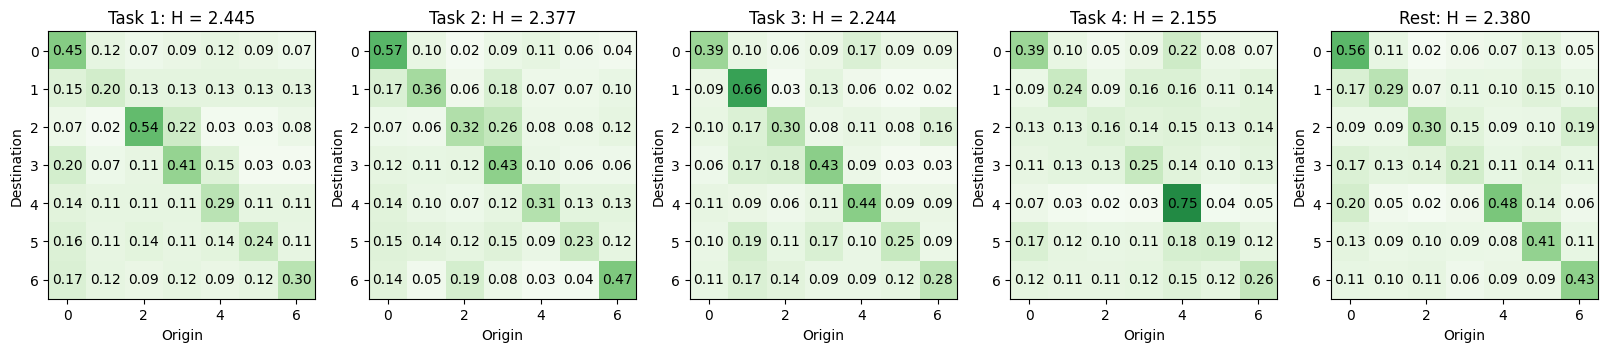

0.9777704526983638


In [21]:
# Compute relativeTaskInconsistency
rel_task_incon = ms.relative_task_inconsistency(models[:-1], models[-1], visualize=True)
print(rel_task_incon)